# Orchestrating LLMs to Write Diverse Stories with Quality Diversity through AI Feedback

by [Bryon Tjanaka](https://btjanaka.net/); edited and reviewed by [Andrew Dai](https://daia99.github.io/), [Saeed Hedayatian](https://conflictednerd.github.io/), and [Sid Srikanth](https://sidsrikanth.com/)

_This tutorial is part of the series of pyribs tutorials! See [here](https://docs.pyribs.org/en/latest/tutorials.html) for the list of all tutorials and the order in which they should be read._

Given a creative writing task like "write a story about a spy and a politician," there are many possible interpretations. For instance, we could write a story that ends with the spy getting away with classified information. Or one where the spy and politician put aside their differences and team up to overthrow a government. Or even one where the spy and politician fall in love and leave their lives behind. In short, a wide range of stories exist, each with their own unique plot and details.

<figure style="width: 50%; margin-left: auto; margin-right: auto;">

![](_static/spy-and-politician.png)

<figcaption style="text-align: center; font-style: italic">"An image of a suspicious spy and a rich politician." Generated with ChatGPT.</figcaption>
</figure>

To explore the range of such possibilities, [Quality Diversity through AI Feedback (QDAIF; Bradley 2024)](https://qdaif.github.io/) proposes to orchestrate LLMs in two ways. First, QDAIF uses LLMs to _generate_ new stories. Given a story, QDAIF prompts the LLM to mutate the story into a new one. Second, and equally as important, QDAIF leverages LLMs to _evaluate_ each story, by determining whether the story is high-quality and whether it is diverse compared to other stories. In other words, the LLMs compute the _objective_ and _measure_ functions of a quality diversity problem. Thus, QDAIF can repeatedly generate and evaluate stories, eventually producing an archive of diverse stories.

In this tutorial, we will demonstrate how to implement a variation of QDAIF in pyribs on the task of writing a story about a spy and a politician. We will show how to evaluate each story, set up the QD algorithm components, run the algorithm, and visualize the results. We hope that this tutorial will help connect folks in the QD and LLM communities by making it easier to implement algorithms that combine these two methods.

_Since this tutorial involves running LLMs, we recommend running it on a machine with a GPU, either on Colab or on a local workstation. It is possible to run on CPU on a standard laptop, although it will be much slower. Alternatively, if you would like to use an API such as OpenAI or Google Gemini, it should be possible to set that up (more details below)._

## Setup

First, let's set up the prerequisites for this tutorial.

### Python Dependencies

In addition to pyribs, this tutorial depends on [LangChain](https://python.langchain.com/docs/introduction/), a framework for developing LLM applications, and `langchain-ollama`, the package that integrates LangChain with Ollama.

In [ ]:
%pip install ribs[visualize] langchain langchain-ollama tqdm itables moviepy

### Instantiating an LLM with LangChain and Ollama

To make this tutorial flexible to the choice of LLM, we use [LangChain](https://python.langchain.com/docs/introduction/). Among other things, LangChain provides a common interface for operating with LLMs from providers like OpenAI and Google. In this tutorial, we will use LangChain's integration with [Ollama](https://ollama.com). Ollama is a framework that enables efficiently running LLMs on local machines. In other words, _we will use LangChain to call an LLM hosted locally by Ollama_.

If you are running this tutorial on your own machine, please follow the [installation instructions](https://ollama.com/download) for Ollama and skip the cell below (but execute the ones after it). If you are running on Google Colab, install Ollama using the cell below, which was adapted from this [notebook](https://colab.research.google.com/github/5aharsh/collama/blob/main/Ollama_Setup.ipynb) by Saharsh Anand.

**Note:** If you would like to use an LLM from an API like OpenAI or Google Gemini, LangChain also provides integrations for many APIs; more details (such as how to use `init_chat_model`) are available [here](https://python.langchain.com/docs/tutorials/llm_chain/). In that case, feel free to skip this section and instantiate a `model` variable on your own. Note that we assume the model is a _chat model_, i.e., an instance of [BaseChatModel](https://python.langchain.com/api_reference/core/language_models/langchain_core.language_models.chat_models.BaseChatModel.html).

In [ ]:
!sudo apt update
!sudo apt install -y pciutils
!curl -fsSL https://ollama.com/install.sh | sh

After installing Ollama, we start the Ollama server in the background. If Ollama is already running, this cell will output an error that the address is already in use. _This is perfectly fine; simply proceed to the next steps._

In [1]:
import subprocess
import threading
import time


def run_ollama_serve():
    subprocess.Popen(["ollama", "serve"])


thread = threading.Thread(target=run_ollama_serve)
thread.start()
time.sleep(5)  # Wait for the server to start.

Error: listen tcp 127.0.0.1:11434: bind: address already in use


We can now pull the LLM from Ollama's library and instantiate it in LangChain. We have chosen [Llama 3.1](https://ollama.com/library/llama3.1:8b-instruct-q4_K_M), specifically the 8B parameter version finetuned for instruction following. We choose the `q4_K_M` [quantization](https://github.com/ggml-org/llama.cpp/blob/master/tools/quantize/README.md) as it is a recommended size that balances between speed/memory usage and accuracy. For alternative models, visit the Ollama library [here](https://ollama.com/library). One example alternative is `llama3.1:70b-instruct-q4_K_M` (70B version of Llama 3.1).

In [2]:
from langchain_ollama import ChatOllama

model_name = "llama3.1:8b-instruct-q4_K_M"  # @param ["llama3.1:8b-instruct-q4_K_M","llama3.1:70b-instruct-q4_K_M"] {"allow-input":true}

# Pull the model from the Ollama library.
!ollama pull {model_name}
print("---")

# Instantiate the model in LangChain.
model = ChatOllama(model=model_name)
print("Model:", model)

pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest 
pulling 667b0c1932bc: 100% ▕██████████████████▏ 4.9 GB                         
pulling 948af2743fc7: 100% ▕██████████████████▏ 1.5 KB                         
pulling 0ba8f0e314b4: 100% ▕██████████████████▏  12 KB                         
pulling 56bb8bd477a5: 100% ▕██████████████████▏   96 B                         
pulling 455f34728c9b: 100% ▕██████████████████▏  487 B                         
verifying sha256 digest 
writing manifest 
success 
---
Model: model='llama3.1:8b-instruct-q4_K_M'


## Problem Statement

In this tutorial, we frame the problem of writing stories as a _quality diversity (QD) optimization_ problem. QD seeks to find a diverse set of high-performing solutions/stories (we use "solutions" and "stories" interchangeably in this tutorial; solutions is the general term). Performance is defined in terms of an _objective_, and diversity is defined with respect to a vector-valued _measure_ function. The solutions in the set should individually maximize the objective while collectively attaining every possible output of the measure function.

We define the following objective and measures. These definitions are adapted from the Stories domain in the original QDAIF paper (Bradley 2023), where the measures are slightly different.

- **Objective:** Is the story a high-quality short story about a suspicious spy and a rich politician?
- **Measure 0:** Is the story a romance story?
- **Measure 1:** Does the story have a happy ending?

To illustrate, our final set of solutions may contain stories like:

- A story about a spy and a policitican that is a _romance_ story with a _happy_ ending.
- A story about a spy and a policitican that is _not a romance_ story with an _unhappy_ ending.
- A story about a spy and a policitican that is _not a romance_ story with an ending that is _neither happy nor sad_.

## AI Feedback with an Evaluator

The first ingredient for QDAIF is an evaluator that calls the LLM to evaluate the objective and measures defined in the problem statement above. For each objective and measure, we write a prompt (which we will show later) and pass it to the LLM. From there, we can extract the LLM's score for each prompt in one of many ways. For example, the original QDAIF paper predominantly extracts scores by asking the LLM to output an answer like yes or no and analyzing the logits of the tokens associated with that answer. Notably, this approach requires access to the logits output by the LLM, and logits are not always available. Thus, in this tutorial, we instead ask the LLM to output a rating on a scale of 1 to 10 when evaluating the objective and each measure. This approach is general in that it works with any LLM, but a key drawback is that the rating is stochastic and requires multiple evaluations.

The `Evaluator` class below implements this approach. Note the `n_evals` parameter that determines how many times to evaluate the objective and each measure. The final score for the objective and each measure is averaged over the ratings from the `n_evals` evaluations.

In [3]:
import numpy as np
from langchain_core.language_models.chat_models import BaseChatModel
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.base import Runnable
from pydantic import BaseModel, Field


class Evaluator:
    """Manages an LLM to compute the objective and measures.

    Args:
        model: Chat model for computing evaluations.
        objective_prompt: Prompt for the objective.
        measure_0_prompt: Prompt for the first measure (measure 0).
        measure_1_prompt: Prompt for the second measure (measure 1).
        n_evals: Number of times to evaluate the objective and each measure.
    """

    def __init__(
        self,
        *,
        model: BaseChatModel,
        objective_prompt: str,
        measure_0_prompt: str,
        measure_1_prompt: str,
        n_evals: int,
    ):
        self.model = model
        self.n_evals = n_evals
        self.min_score = 1
        self.max_score = 10

        # To receive the output from the LLM in a consistent format, we use structured
        # output (https://python.langchain.com/docs/how_to/structured_output/). This
        # Pydantic model defines the schema for receiving ratings from the LLM. Note
        # that the text in the schema class (including class name, field name, field
        # description, docstrings) all have some influence on the LLM output.
        class Rating(BaseModel):
            rating: int = Field(description="The rating on a scale of 1 to 10.")

        # Objective. We first define a chat template, where the `objective_prompt`
        # passed in is the system prompt, and the `text` of the story is the user's
        # message. Then, we form a chain that connects this template to the model. We
        # do the same for measure 0 and measure 1 below. For more background on
        # LangChain, refer to the documentation, such as:
        # - https://python.langchain.com/docs/tutorials/llm_chain/
        # - https://python.langchain.com/docs/concepts/lcel/
        self.objective_template = ChatPromptTemplate(
            [("system", objective_prompt), ("user", "{text}")]
        )
        self.objective_chain = (
            self.objective_template | self.model.with_structured_output(Rating)
        )

        # Measure 0.
        self.measure_0_template = ChatPromptTemplate(
            [("system", measure_0_prompt), ("user", "{text}")]
        )
        self.measure_0_chain = (
            self.measure_0_template | self.model.with_structured_output(Rating)
        )

        # Measure 1.
        self.measure_1_template = ChatPromptTemplate(
            [("system", measure_1_prompt), ("user", "{text}")]
        )
        self.measure_1_chain = (
            self.measure_1_template | self.model.with_structured_output(Rating)
        )

    def compute_score(self, chain: Runnable, texts: list[str]):
        """Uses the given chain to compute scores for the given batch of input texts.

        Each text input is evaluated `n_evals` times.

        Two values are returned:
        - The first value is `all_scores`, which is a list where each entry contains the
          `n_evals` scores for each text.
        - The second is `mean_scores`, which is the mean score for each piece of text.
        """
        inputs = [{"text": text} for text in texts for _ in range(self.n_evals)]
        outputs = chain.batch(inputs)

        all_scores = []
        mean_scores = []

        for i in range(0, len(outputs), self.n_evals):
            results = outputs[i : i + self.n_evals]
            scores = []
            for r in results:
                # Note: this assumes the schema for each result has a `rating` field,
                # which may not be the case if you modify the schema above.
                score = np.clip(r.rating, self.min_score, self.max_score)
                scores.append(score)

            scores = np.asarray(scores)
            all_scores.append(scores)
            mean_scores.append(scores.mean())

        return all_scores, np.asarray(mean_scores)

    def evaluate(self, texts: list[str]):
        objectives = self.compute_score(self.objective_chain, texts)[1]
        measure_0 = self.compute_score(self.measure_0_chain, texts)[1]
        measure_1 = self.compute_score(self.measure_1_chain, texts)[1]
        measures = np.stack((measure_0, measure_1), axis=1)
        return objectives, measures

Having defined the `Evaluator`, we now instantiate it with the `model` (defined above in Setup), the prompts for the objective and measures, and the number of evaluations `n_evals`. Each prompt starts with defining a characteristic of the story and ends with asking the LLM to output a rating from 1 to 10. Feel free to customize the prompts to specify different objectives and measures!

In [4]:
evaluator = Evaluator(
    model=model,
    objective_prompt="Determine if the input text contains a high-quality short story containing two characters, a suspicious spy, and a rich politician. For example, a high-quality short story would have good flow, interesting plot, and not repeat similar sentences or undesired items such as titles and URLs. Output your rating on a scale of 1 to 10. Output only a single integer.",
    measure_0_prompt="Determine if the input text is a romance story. For example, a romance story talks about two characters who fall in love with each other. Output your rating on a scale of 1 to 10. Output only a single integer.",
    measure_1_prompt="Determine if the input text is a story with a happy ending. For example, a story where the two characters make peace with each other has a happy ending. Output your rating on a scale of 1 to 10. Output only a single integer.",
    n_evals=5,
)

As an example, let's use the `Evaluator` to evaluate two stories.

In [5]:
objectives, measures = evaluator.evaluate(
    [
        "The rich politician, Tom’s life took a turn for the worst - he feared all of his close aides all of a sudden after sensing danger in his clique. There was a civil war going on, and he feared for his life. One day, one of his security guards, turned secret agent, decided to sneak into the classified files room, and spied on Johnny, who was in the room. He wanted to find Johnny’s weakness, and strike at the right time.",
        "Jack was a politician in the city when one day he met Sarah. Sarah had been working for the government as a secret spy. Jack decided he really liked Sarah, and they fell in love. They both quite their jobs and decided to live in the countryside together.",
    ]
)

for i, (obj, meas) in enumerate(zip(objectives, measures)):
    print(f"Story {i} | Objective: {obj}, Measure 0: {meas[0]}, Measure 1: {meas[1]}")

Story 0 | Objective: 6.6, Measure 0: 1.8, Measure 1: 2.4
Story 1 | Objective: 7.4, Measure 0: 8.0, Measure 1: 9.2


## QDAIF Components in pyribs

QDAIF builds on the MAP-Elites framework ([Mouret 2015](https://arxiv.org/abs/1504.04909)). Broadly speaking, MAP-Elites maintains an archive for storing the solutions to a QD problem. During execution, it selects solutions from this archive, mutates them, and inserts them back into the archive. In pyribs, this workflow is implemented with three components: an archive, emitters, and a scheduler. Below we describe each component and its functionality.

### GridArchive for Storing Stories

The archive for QDAIF is a [`GridArchive`](https://docs.pyribs.org/en/latest/api/ribs.archives.GridArchive.html), which divides the measure space into a grid and stores a solution in each grid cell. When a solution is added to this archive, it is assigned to a grid cell based on its measure values. If there is already a solution in that cell, the archive only retains the solution that has the higher objective value.

Below, we specify a $20 \times 20$ grid (`dims`) where each side of the grid ranges from 1 to 10 (`ranges`). For those familiar with `GridArchive` from previous tutorials, several other settings are needed since this `GridArchive` stores text-based solutions, whereas previous tutorials involved continuous vectors. First, we set `solution_dim=()`, indicating a scalar solution. Second, we set `dtype` such that the `solution` is an `object` while the `objective` and `measures` remain as floating-point values. This way, the archive can store pieces of text, which are single objects of type `str` (i.e., "scalar" objects).

In [6]:
from ribs.archives import GridArchive

archive = GridArchive(
    solution_dim=(),
    dims=[20, 20],
    ranges=[(1, 10), (1, 10)],
    dtype={"solution": object, "objective": np.float32, "measures": np.float32},
)

### Custom Emitter for Generating New Stories

In pyribs, emitters generate new candidate solutions for evaluation. In the case of QDAIF, the emitter generates new stories by randomly selecting existing stories in the archive and mutating them. The original QDAIF performed such mutations with Language Model Crossover from [Meyerson 2023](https://arxiv.org/abs/2302.12170). In this tutorial, we differ from the original QDAIF by implementing "directional" variations inspired by PLAN-QD in [Srikanth 2025](https://arxiv.org/abs/2504.03991).

Specifically, the `LLMDirectionalEmitter` below does the following when its `ask()` method is called. First, it selects a random story from the archive. Next, for each measure, it selects a random direction, either up or down. For instance, for measure 0 in this tutorial, the story can be made to sound more like a romance story or less like a romance story, and for measure 1, the ending of the story can be made more happy or less happy. Having selected a story and these two random directions (one for each measure), the emitter calls the LLM to mutate the story in the given directions, e.g., "given this story, make the story sound more like a romance story, and make the ending more happy." The result is a new story that is then sent for evaluation.

Finally, note that the `LLMDirectionalEmitter` also takes in an `initial_solutions` parameter. These define the initial texts that will be output by the emitter on the first iteration.

In [7]:
from ribs.archives import ArchiveBase
from ribs.emitters import EmitterBase


class LLMDirectionalEmitter(EmitterBase):
    """Uses LLMs to modify pieces of text in random archive directions.

    Args:
        archive: Archive of solutions, e.g., :class:`ribs.archives.GridArchive`. The
            archive must contain solutions of type :class:`str`.
        model: LLM for mutating pieces of text.
        mutation_prompt: Prompt for mutating the text. This prompt must contain fields
            for ``measure_0_direction`` and ``measure_1_direction``.
        measure_*_{down,up}: Prompts indicating directions for mutating the story. Note
            that these directions are inserted into the ``mutation_prompt``.
        batch_size: Number of solutions to return in :meth:`ask`. Note that on the first
            iteration, ``initial_solutions`` will be returned, which may not be of
            length ``batch_size``.
        initial_solutions: Initial pieces of text for the LLM.
        seed: Value to seed the random number generator. Set to None to avoid a fixed
            seed.
    """

    def __init__(
        self,
        archive: ArchiveBase,
        *,
        model: BaseChatModel,
        mutation_prompt: str,
        measure_0_down: str,
        measure_0_up: str,
        measure_1_down: str,
        measure_1_up: str,
        batch_size: int,
        initial_solutions: list[str],
        seed: int | None = None,
    ):
        EmitterBase.__init__(
            self,
            archive,
            solution_dim=archive.solution_dim,
            bounds=None,
        )

        self.model = model
        self.batch_size = batch_size
        self.initial_solutions = initial_solutions
        self.rng = np.random.default_rng(seed)

        # This template provides the mutation prompt as the LLM's system prompt, and
        # then provides the story as the `text` field.
        self.mutation_template = ChatPromptTemplate(
            [("system", mutation_prompt), ("user", "{text}")]
        )

        # Each measure has two possible directions: up or down.
        self.mutation_dirs = {
            "measure_0": [measure_0_down, measure_0_up],
            "measure_1": [measure_1_down, measure_1_up],
        }

        # Schema for retrieving stories from the model.
        class Story(BaseModel):
            story: str = Field(description="The modified story.")

        self.mutation_chain = (
            self.mutation_template | self.model.with_structured_output(Story)
        )

    def ask(self):
        """The ask method returns a list of new solutions/stories for evaluation."""

        # When no solutions have been created yet, just return the initial seed texts.
        if self.archive.empty:
            return self.initial_solutions

        # During normal operation, sample texts and directions to pass to the LLM.
        prompts = []
        for _ in range(self.batch_size):
            # For both measure_0 and measure_1 (hence size=2), choose between the two
            # possible directions.
            dirs = self.rng.choice(2, size=2)

            prompts.append(
                {
                    "text": self._archive.sample_elites(1)["solution"][0],
                    "measure_0_direction": self.mutation_dirs["measure_0"][dirs[0]],
                    "measure_1_direction": self.mutation_dirs["measure_1"][dirs[1]],
                }
            )

        stories = self.mutation_chain.batch(prompts)
        return [s.story for s in stories]

Below, we instantiate the emitter with prompts to enable making the story more/less romantic and the ending more/less happy. We also provide three initial stories (`initial_solutions`) drawn from the QDAIF paper. Feel free to modify any of the prompts or the initial stories.

To save on computation, we have only defined one emitter with a batch size of 1, so we only generate 1 solution per iteration. We also use the same `model` that is used by the `Evaluator`, so that we do not have to load another model. It is certainly possible to increase the batch size of each emitter, create multiple emitters that each perform mutations with different prompts, or use different models than that used in the `Evaluator`. If you have the time, we encourage trying out these ideas!

In [8]:
emitters = [
    LLMDirectionalEmitter(
        archive,
        model=model,
        mutation_prompt="The following is a story about two characters, a suspicious spy, and a rich politician. Modify the story in the following ways: {measure_0_direction}, and {measure_1_direction}. Output only the new story.",
        measure_0_down="make the story sound less like a romance story",
        measure_0_up="make the story sound more like a romance story",
        measure_1_down="make the ending of the story less happy",
        measure_1_up="make the ending of the story more happy",
        batch_size=1,
        initial_solutions=[
            # From QDAIF paper (Appendix A.21).
            "A spy named Joanne wants to infiltrate the premises of Karl Johnson, a highly-influential figure in the city. Karl was a wealthy mayor, and would do anything in his power to suppress any opposing voices. Joanne wanted to figure out what Karl was hiding, but she took a turn for the worse, as she was highly suspicious in her presence outside his home.",
            "The wealthy entrepreneur and member of parliament, Susan, hosted a party at her mansion. She invited all of the residents, as well as an unusual looking man. The man, Dave, was wearing a tacky shirt, and star-shaped glasses, and was actually a spy. He made the whole room laugh with his jokes, and had a secret agenda - to find what Susan does in her private fun room!",
            "The rich politician, Tom’s life took a turn for the worst - he feared all of his close aides all of a sudden after sensing danger in his clique. There was a civil war going on, and he feared for his life. One day, one of his security guards, turned secret agent, decided to sneak into the classified files room, and spied on Johnny, who was in the room. He wanted to find Johnny’s weakness, and strike at the right time.",
        ],
    ),
    # Additional emitters would go here (`emitters` is a list of emitters).
]

### Scheduler for Composing QDAIF

To compose the archive and emitters for QDAIF together, we instantiate a [`Scheduler`](https://docs.pyribs.org/en/latest/api/ribs.schedulers.Scheduler.html). The scheduler handles the QD algorithm logic like calling the archive and emitters.

In [9]:
from ribs.schedulers import Scheduler

scheduler = Scheduler(archive, emitters)

## Visualizing the QDAIF Archive

Before we run QDAIF with the scheduler, we must introduce one last ingredient that will help understand the outputs of the algorithm. Using [`grid_archive_heatmap`](https://docs.pyribs.org/en/latest/api/ribs.visualize.grid_archive_heatmap.html) from the [`ribs.visualize`](https://docs.pyribs.org/en/latest/api/ribs.visualize.html) module, we can plot a heatmap of the archive that shows all the stories generated. The axes correspond to the two measures, while the color of each cell shows the objective. For now, the heatmap is empty, but it will fill up as QDAIF progresses.

In [10]:
from pathlib import Path

import matplotlib.pyplot as plt
from ribs.visualize import grid_archive_heatmap


def plot_heatmap(archive, show=False, file=None):
    """Plots the archive.

    Pass `show` to display the heatmap with plt.show().
    Pass `file` to save to the given file.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
    grid_archive_heatmap(archive, ax=ax, vmin=1, vmax=10)
    ax.set_title("A story about a suspicious spy and a rich politician.")
    ax.set_xlabel("Romance Story")
    ax.set_ylabel("Happy Ending")
    ax.set_aspect("equal")
    fig.tight_layout()
    if file is not None:
        fig.savefig(file)
    if show:
        plt.show()
    plt.close(fig)

Below, we also set up a logging directory in `qdaif_output/`. **Note that this cell will also remove any existing `qdaif_output/` directory!**

In [11]:
import shutil

output_dir = Path("qdaif_output/")
shutil.rmtree(output_dir, ignore_errors=True)
output_dir.mkdir()

And now, we plot the initial heatmap:

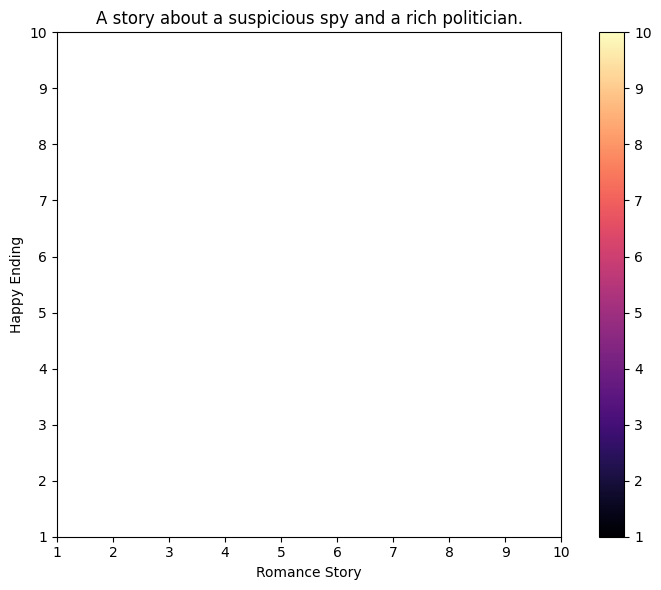

In [12]:
plot_heatmap(archive, show=True, file=output_dir / f"heatmap_{0:06d}.png")

## Running QDAIF

With the components created, we can execute QDAIF in the loop below. During this loop, we first call `ask` on the `scheduler`, which generates new stories (`solutions`) by calling the `ask` method defined on `LLMDirectionalEmitter` above. After evaluating the `objectives` and `measures` of the stories, we pass them to the `scheduler` with `tell`, which inserts the stories into the `archive`. Along the way, we regularly log metrics and save the archive data as a CSV.

On a T4 GPU on Colab, this loop should take **~1 hour** to run. It was also tested locally on an RTX A6000 GPU, where it took around half an hour to run.

In [ ]:
import pickle as pkl
import sys

from tqdm import tqdm, trange

total_itrs = 200

for itr in trange(1, total_itrs + 1, file=sys.stdout, desc="Iterations"):
    solutions = scheduler.ask()
    objectives, measures = evaluator.evaluate(solutions)
    scheduler.tell(objectives, measures)

    if itr % 5 == 0 or itr == total_itrs:
        tqdm.write(
            f"Iteration {itr:5d} | "
            f"Archive Coverage: {archive.stats.coverage * 100:6.3f}%  "
            f"QD Score: {archive.stats.qd_score:6.3f}"
        )

        # Save the archive's data as a CSV, which makes it easy to read the stories.
        archive.data(return_type="pandas").to_csv("qdaif_archive.csv")

        # Plot the heatmap in the output directory defined earlier. To avoid crowding
        # the logs, we show the heatmap much less frequently than we plot it.
        plot_heatmap(
            archive,
            show=itr % 50 == 0 or itr == total_itrs,
            file=output_dir / f"heatmap_{itr:06d}.png",
        )

Iteration     5 | Archive Coverage:  1.750%  QD Score: 51.800                                 
Iterations:   4%|█▊                                           | 8/200 [01:35<39:36, 12.38s/it]

## Final Archive Heatmap and Video

Below we show the final heatmap of the archive.

In [ ]:
plot_heatmap(archive, show=True, file=None)

Having plotted the heatmaps during the run, we can also connect them all into a single video with `moviepy`.

In [ ]:
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip

clip = ImageSequenceClip(list(map(str, output_dir.glob("heatmap_*.png"))), fps=6)
clip.display_in_notebook()

## Reading Generated Stories

Having visualized the archive, we can take a look at some of the individual stories. The function below retrieves a story from the archive with the given measures and prints it out. Specifically, the [`retrieve_single`](https://docs.pyribs.org/en/latest/api/ribs.archives.GridArchive.html#ribs.archives.GridArchive.retrieve_single) method locates the cell with the given measures and returns the elite in that cell if it exists.

In [ ]:
import textwrap


def retrieve_and_print(archive, measures):
    occupied, elite = archive.retrieve_single(measures)

    if occupied:
        print(f"Objective: {elite['objective']:.3f}")
        print(f"Measure 0 (Romance Story): {elite['measures'][0]:.3f}")
        print(f"Measure 1 (Happy Ending): {elite['measures'][1]:.3f}")
        print("-" * 20)
        print(textwrap.fill(elite["solution"], 80))
    else:
        print("No solution available with the given measures.")

First, we can look at some stories that had high ratings for being both a romance story and having a happy ending.

In [ ]:
retrieve_and_print(archive, [9, 10])

In [ ]:
retrieve_and_print(archive, [8, 7.5])

Next, we can look at stories that were rated low on both measures.

In [ ]:
retrieve_and_print(archive, [1.8, 2.8])

In [ ]:
retrieve_and_print(archive, [3.0, 2.0])

And finally, one that was rated as a romance story but not with a happy ending.

In [ ]:
retrieve_and_print(archive, [8, 2])

## Listing All Stories in a Table

Using the [data](https://docs.pyribs.org/en/latest/api/ribs.archives.GridArchive.html#ribs.archives.GridArchive.data) method, we can retrieve a dataframe with all the data in the archive. Then, we can display this table with [itables](https://mwouts.github.io/itables/).

In [ ]:
import itables

itables.init_notebook_mode(all_interactive=False)

df = archive.data(return_type="pandas")

# See here for more info on `classes`: https://datatables.net/manual/styling/classes
# The `columnDefs` sets the `solution` column (i.e., the target is 0, which is the
# first column) to have left-aligned text ("dt-body-left") -- see Cell classes here:
# https://datatables.net/manual/styling/classes#Cell-classes and this issue here:
# https://github.com/mwouts/itables/issues/22
itables.show(
    df,
    classes="display",
    columnDefs=[{"className": "dt-body-left", "targets": 0}],
)

## Conclusion

There has been a growing number of works at the intersection of QD and LLMs, with QDAIF being one of the first to leverage this synergy. We hope this tutorial will enhance the accessibility of such methods! We envision that it should be easy for LLM folks to use QD, and for QD folks to use LLMs.

This tutorial showed just one application of such methods, for generating stories about "a suspicious spy and a rich politician." However, there are many further applications, such as for [red-teaming LLMs](https://sites.google.com/view/rainbow-teaming). In this tutorial itself, there is also ample room for extension. For example, you may have noticed that some stories have issues with coherence, where they jump around or change certain details. Furthermore, while most stories have nice prose, many are incomplete, in that they lack a coherent beginning, middle, and end. Finally, the ratings associated with the stories are occasionally inaccurate, e.g., some are rated as having a happy ending when the ending sounds quite sad. We hypothesize that many of these issues stem from the inherent quirks of working with LLMs, and perhaps tuning the various prompts, increasing the number of evaluations (`n_evals`), or even just running for longer (200 iterations is very few) may help. We encourage you to try things out for yourself and see what works!

## Citation

If you find this tutorial useful, please cite it as:

```
@article{pyribs_qdaif,
  title   = {Orchestrating LLMs to Write Diverse Stories with Quality Diversity through AI Feedback},
  author  = {Bryon Tjanaka},
  journal = {pyribs.org},
  year    = {2025},
  url     = {https://docs.pyribs.org/en/stable/tutorials/qdaif.html}
}
```

The QDAIF paper may be cited as:

```
@inproceedings{
  bradley2024qualitydiversity,
  title = {Quality-Diversity through {AI} Feedback},
  author = {Herbie Bradley and Andrew Dai and Hannah Benita Teufel and Jenny Zhang and Koen Oostermeijer and Marco Bellagente and Jeff Clune and Kenneth Stanley and Gregory Schott and Joel Lehman},
  booktitle = {The Twelfth International Conference on Learning Representations},
  year = {2024},
  url = {https://openreview.net/forum?id=owokKCrGYr}
}
```